# Explore

- `random_state`=123

Plan
- [x] Split data
- [x] Get Univariate Insights
- [ ] Get Bivariate Insights to target (quality)
    - scatterplots with quality on the y
    - correlations + heatmap
    - barplot, swarmplot, and/or boxplot with quality on y and color on x

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import patches

%config InlineBackend.figure_format = 'retina'
import seaborn as sns

import sys
import os
home_directory_path = os.path.expanduser('~')
sys.path.append(home_directory_path +'/utils')

from wrangle import split_data

import explore_utils as e

from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans

from itertools import combinations
import wrangle as w

In [2]:
import warnings
warnings.filterwarnings("ignore")

Acquire and split data

In [3]:
df = pd.read_csv('wine_data.csv') 

train, validate, test = split_data(df, validate_size=.15, test_size=.15, random_state=123)

**Univariate Analysis**

Notes:
- `color`: 75/25, white/red whine
- `quality`: quality is approximately normal. scores of 3 and 9 are rare. 92% have scores 5-7. 44% have a score of 6

QUALITY


,quality,Count,Frequency
0,6,1635,0.439044
1,5,1234,0.331364
2,7,585,0.157089
3,4,143,0.038400
4,8,99,0.026584
5,3,25,0.006713
6,9,3,0.000806


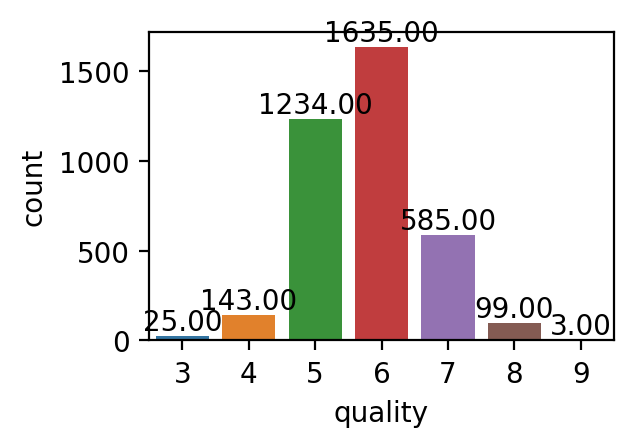


RED


,red,Count,Frequency
0,0,2787,0.748389
1,1,937,0.251611


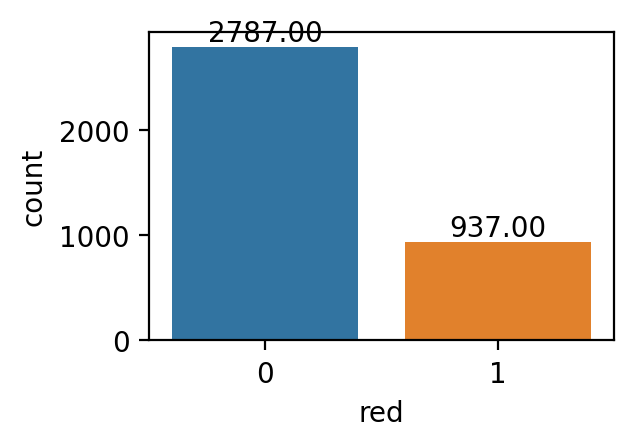

In [4]:
e.explore_univariate_categorical_cols(train)

Descriptive Stats:



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,3724.000000,3724.000000,3724.000000,3724.000000,3724.000000,3724.000000,3724.000000,3724.000000,3724.000000,3724.000000,3724.000000
mean,7.185956,0.344437,0.316114,5.037151,0.056674,30.127148,114.646214,0.994503,3.227368,0.531745,10.544962
std,1.308340,0.168740,0.148539,4.445025,0.035983,17.967870,56.942340,0.002882,0.162114,0.147852,1.189567
min,3.800000,0.080000,0.000000,0.600000,0.012000,1.000000,6.000000,0.987110,2.720000,0.250000,8.000000
25%,6.400000,0.230000,0.240000,1.800000,0.038000,16.000000,76.000000,0.992200,3.120000,0.430000,9.500000
50%,6.900000,0.300000,0.310000,2.700000,0.047000,28.000000,117.000000,0.994655,3.220000,0.510000,10.400000
75%,7.700000,0.410000,0.390000,7.500000,0.066000,41.000000,155.000000,0.996683,3.330000,0.600000,11.400000
max,15.900000,1.580000,1.660000,31.600000,0.611000,289.000000,440.000000,1.010300,4.010000,2.000000,14.900000


------------------------------------------------------------ 
 FIXED ACIDITY 

Most Frequent Values:
6.6    199
6.8    193
6.4    185
Name: fixed acidity, dtype: int64


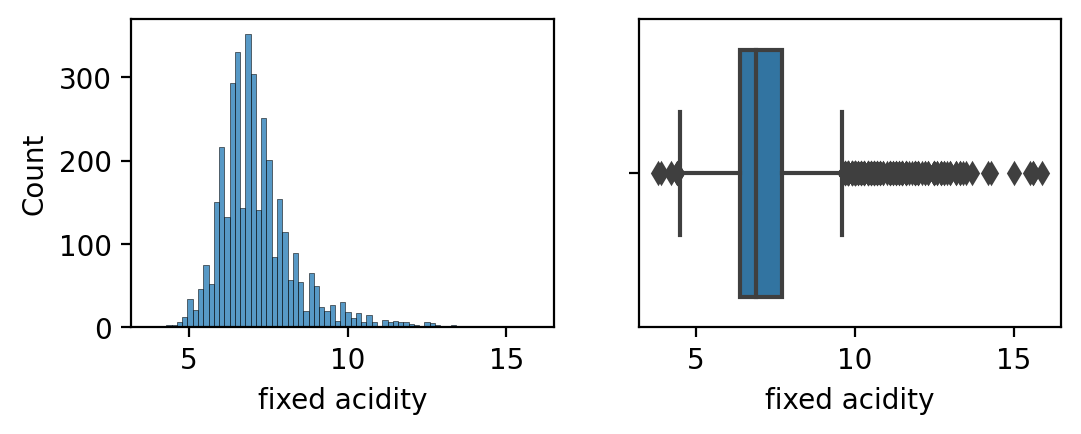


------------------------------------------------------------ 
 VOLATILE ACIDITY 

Most Frequent Values:
0.28    172
0.24    158
0.26    154
Name: volatile acidity, dtype: int64


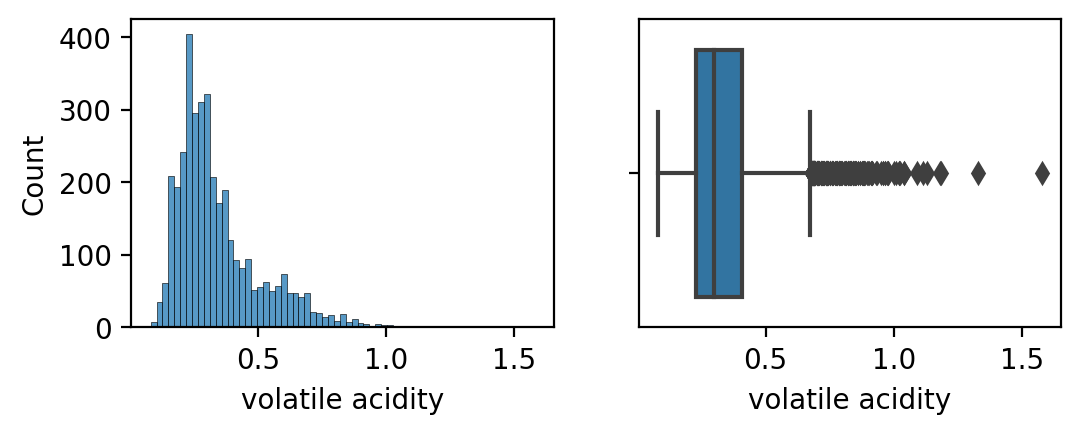


------------------------------------------------------------ 
 CITRIC ACID 

Most Frequent Values:
0.30    187
0.32    163
0.28    163
Name: citric acid, dtype: int64


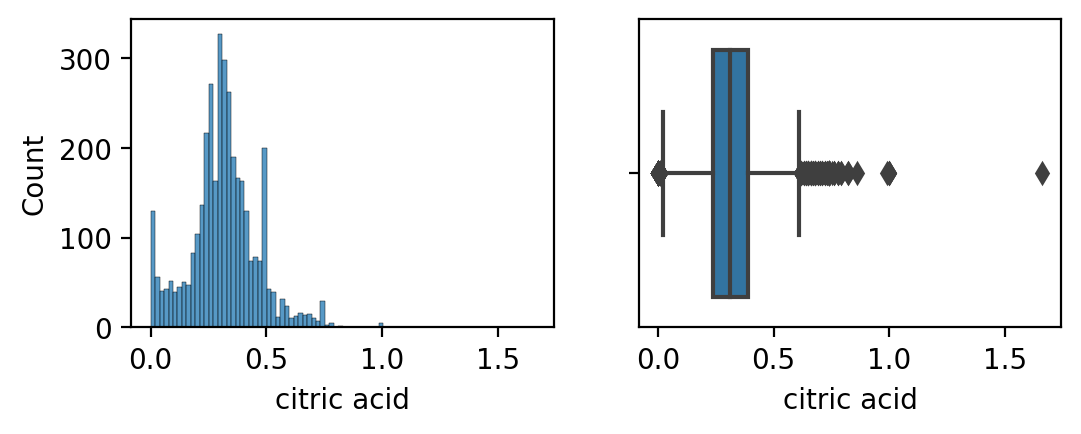


------------------------------------------------------------ 
 RESIDUAL SUGAR 

Most Frequent Values:
1.6    137
1.4    135
2.0    127
Name: residual sugar, dtype: int64


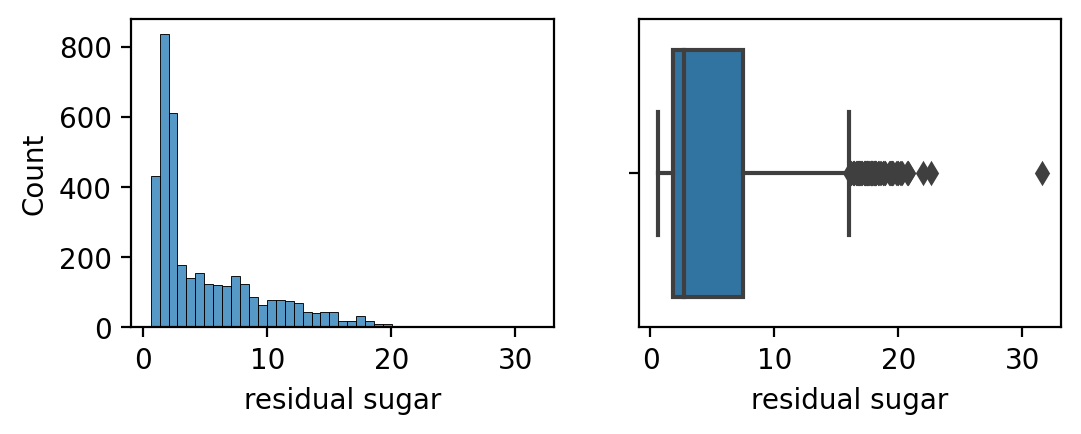


------------------------------------------------------------ 
 CHLORIDES 

Most Frequent Values:
0.042    113
0.044    111
0.036    110
Name: chlorides, dtype: int64


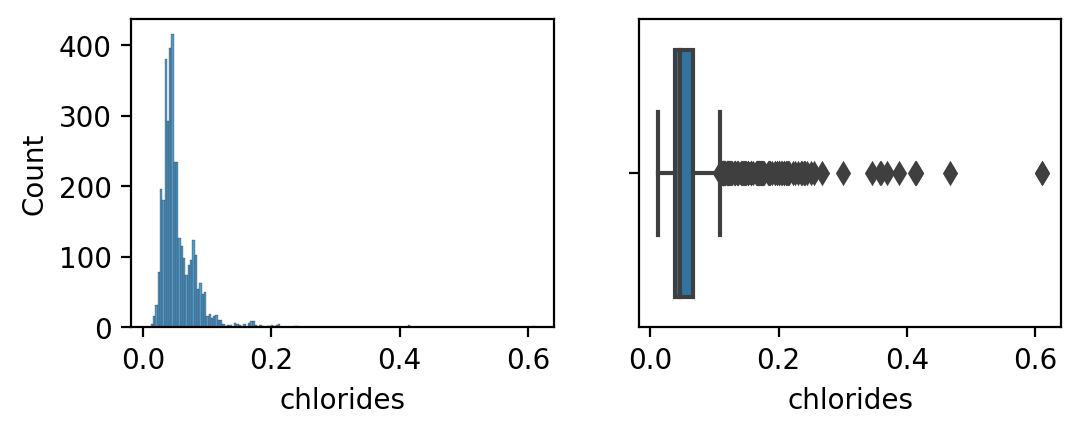


------------------------------------------------------------ 
 FREE SULFUR DIOXIDE 

Most Frequent Values:
29.0    98
6.0     98
26.0    96
Name: free sulfur dioxide, dtype: int64


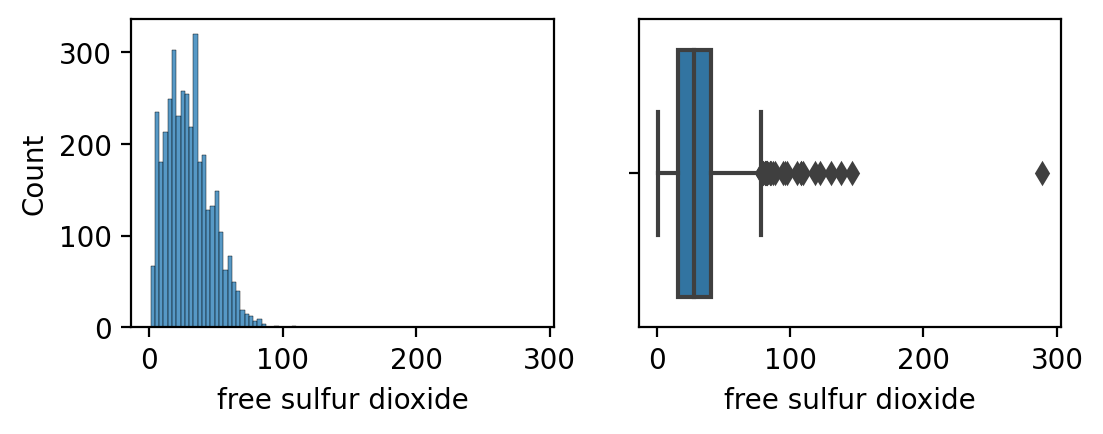


------------------------------------------------------------ 
 TOTAL SULFUR DIOXIDE 

Most Frequent Values:
98.0     39
128.0    36
111.0    36
Name: total sulfur dioxide, dtype: int64


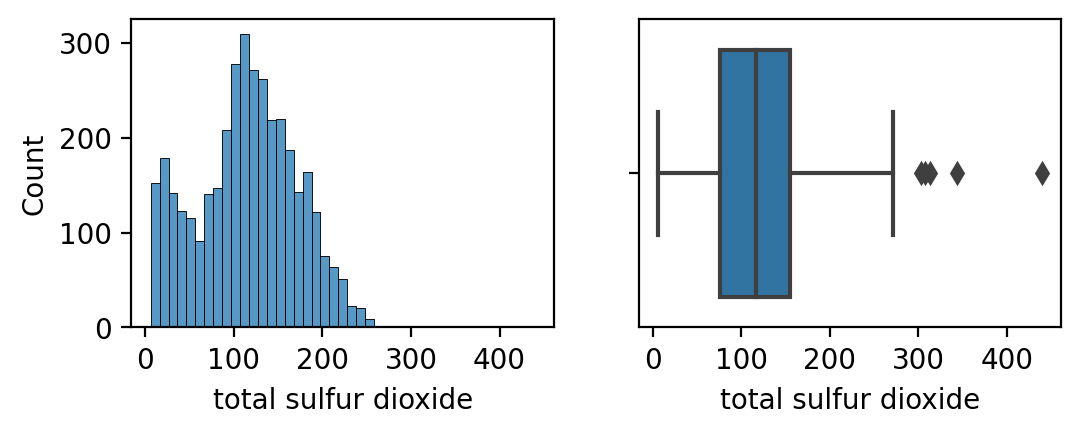


------------------------------------------------------------ 
 DENSITY 

Most Frequent Values:
0.9920    44
0.9934    41
0.9972    41
Name: density, dtype: int64


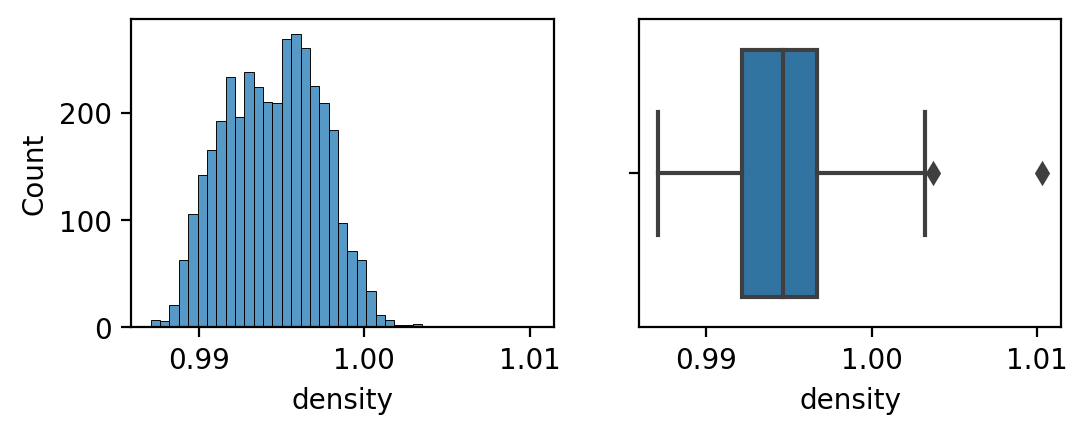


------------------------------------------------------------ 
 PH 

Most Frequent Values:
3.16    108
3.15    106
3.19    101
Name: pH, dtype: int64


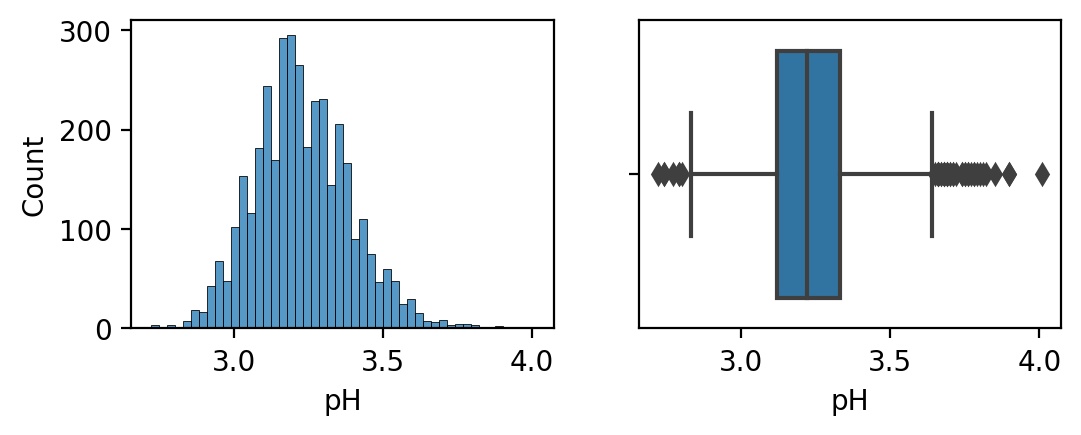


------------------------------------------------------------ 
 SULPHATES 

Most Frequent Values:
0.50    147
0.44    139
0.46    135
Name: sulphates, dtype: int64


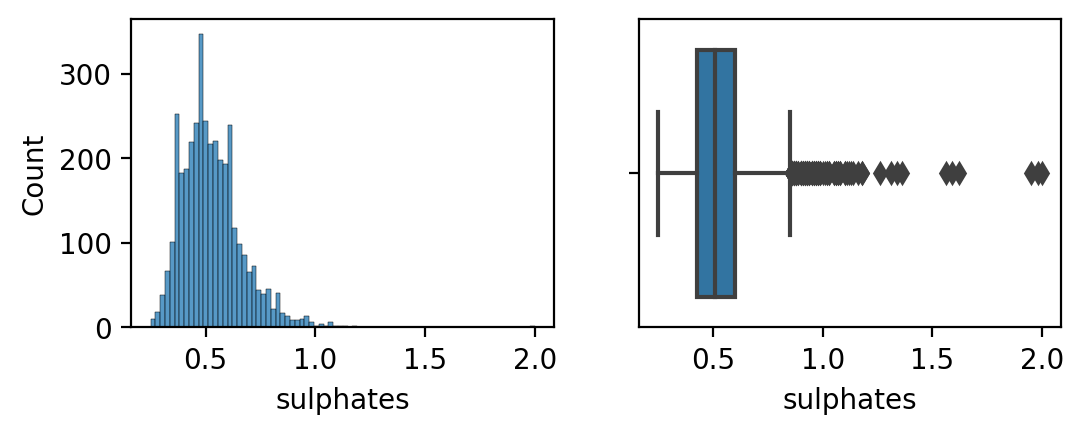


------------------------------------------------------------ 
 ALCOHOL 

Most Frequent Values:
9.5    200
9.4    195
9.2    148
Name: alcohol, dtype: int64


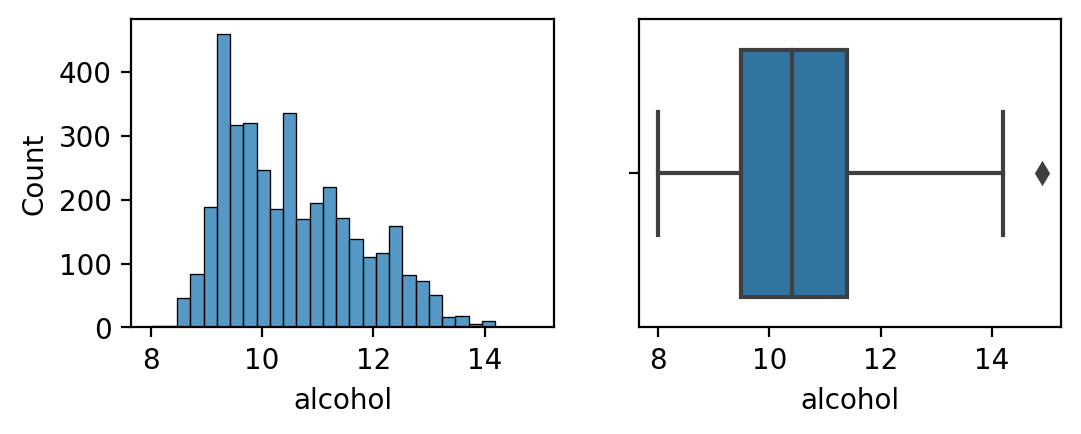

In [5]:
e.explore_univariate_continuous_cols(train)

**Bivariate Analysis**

- color of the wine seems independent of quality
- Features that drive quality: $r > .2$
    - `['alcohol', 'density', 'volatile acidity', 'chlorides' ]`
- Features that don't drive quality: $r < .1$
    - `['color', 'fixed acidity', 'citric acid', 'residual sugar',
        'free sulfur dioxide', 'total sulfur dioxide', 'pH', 'sulphates']`, 

red group quality stats


red,0,1
count,2787.000000,937.000000
mean,5.846789,5.598719
std,0.886927,0.821141
min,3.000000,3.000000
25%,5.000000,5.000000
50%,6.000000,6.000000
75%,6.000000,6.000000
max,9.000000,8.000000


red group quality averages


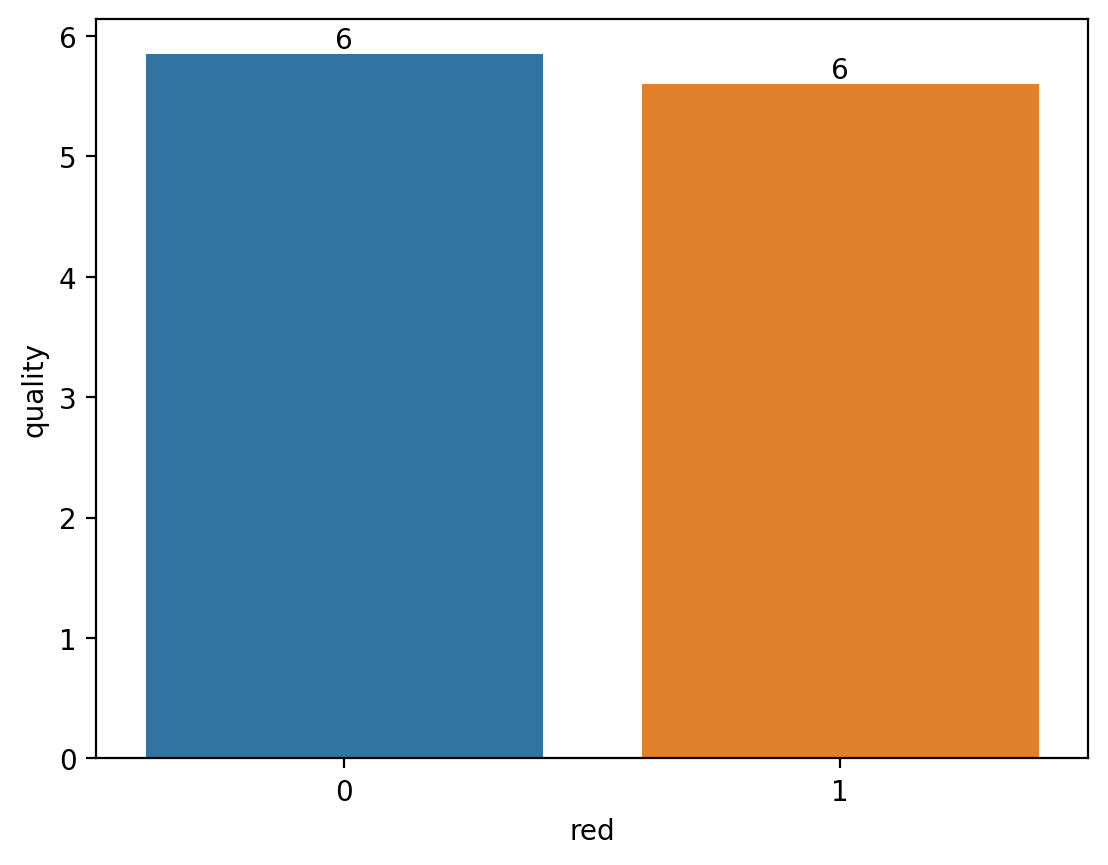

red group quality distributions


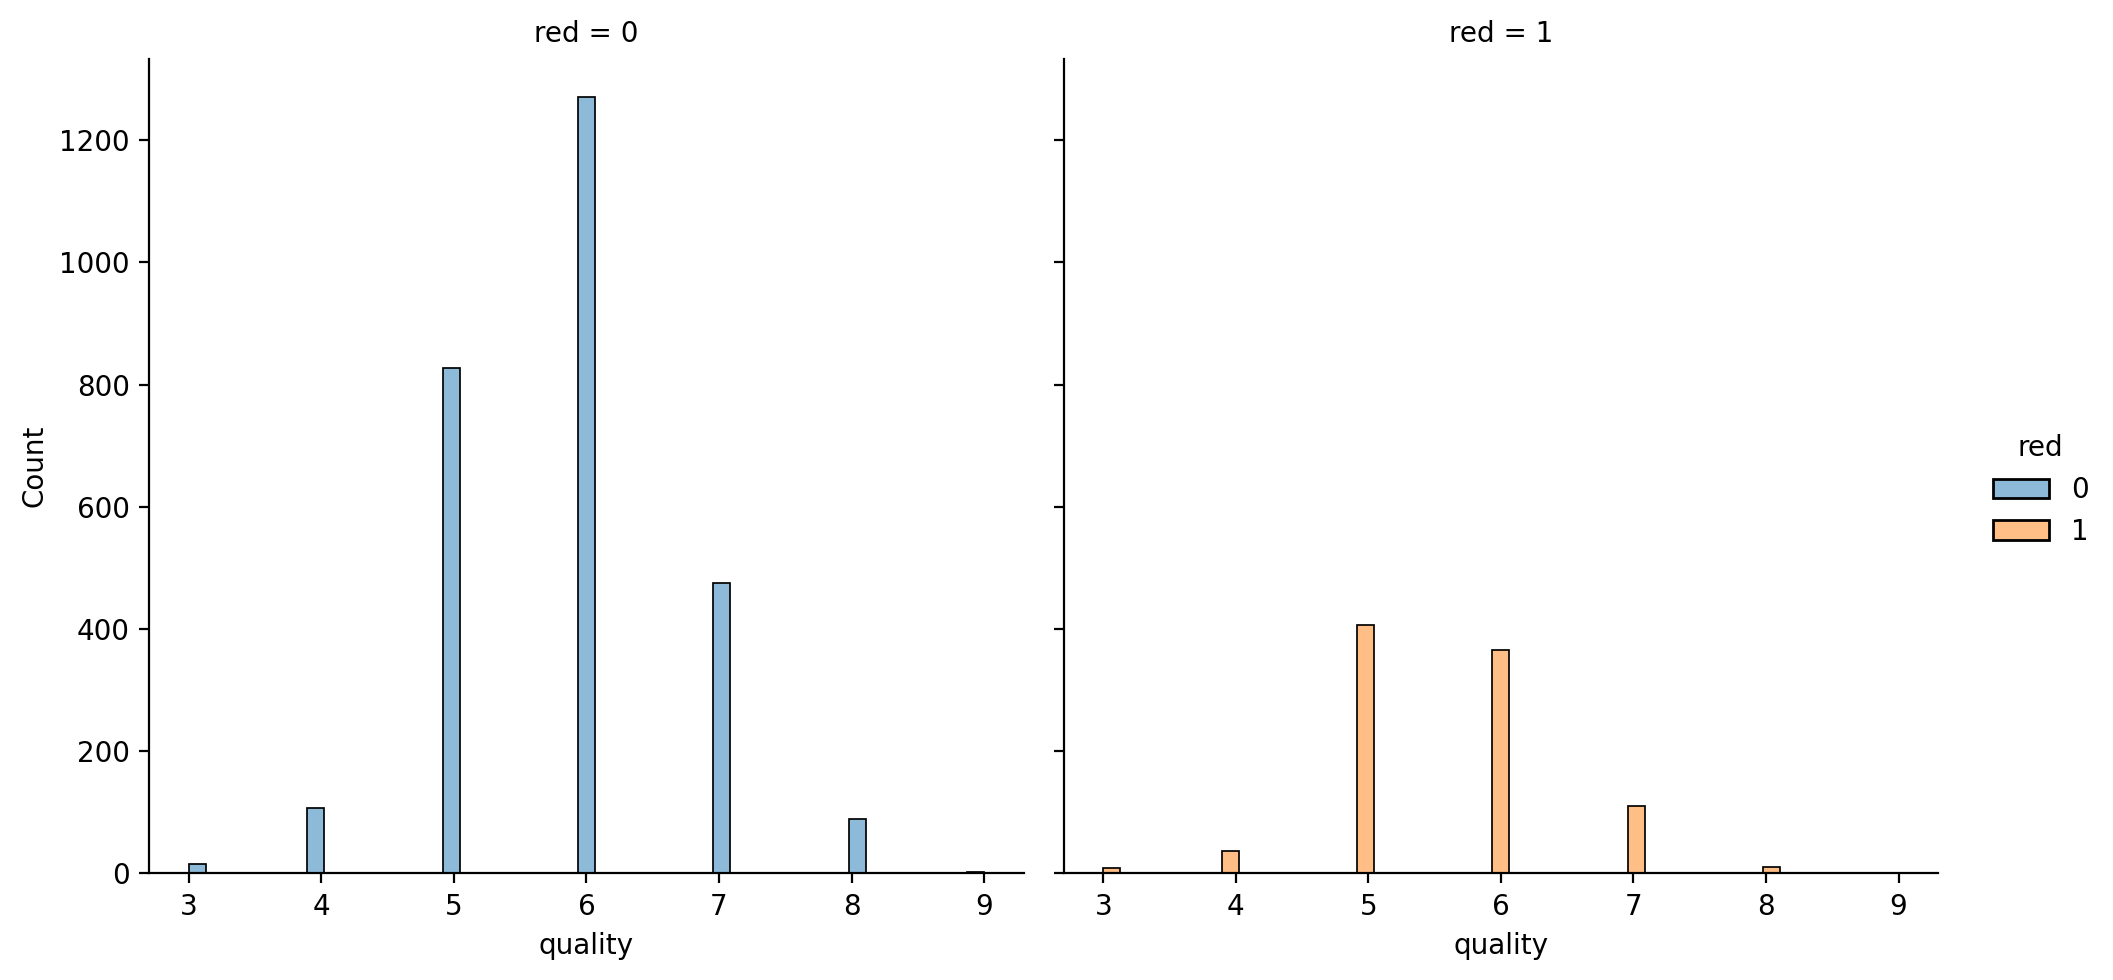

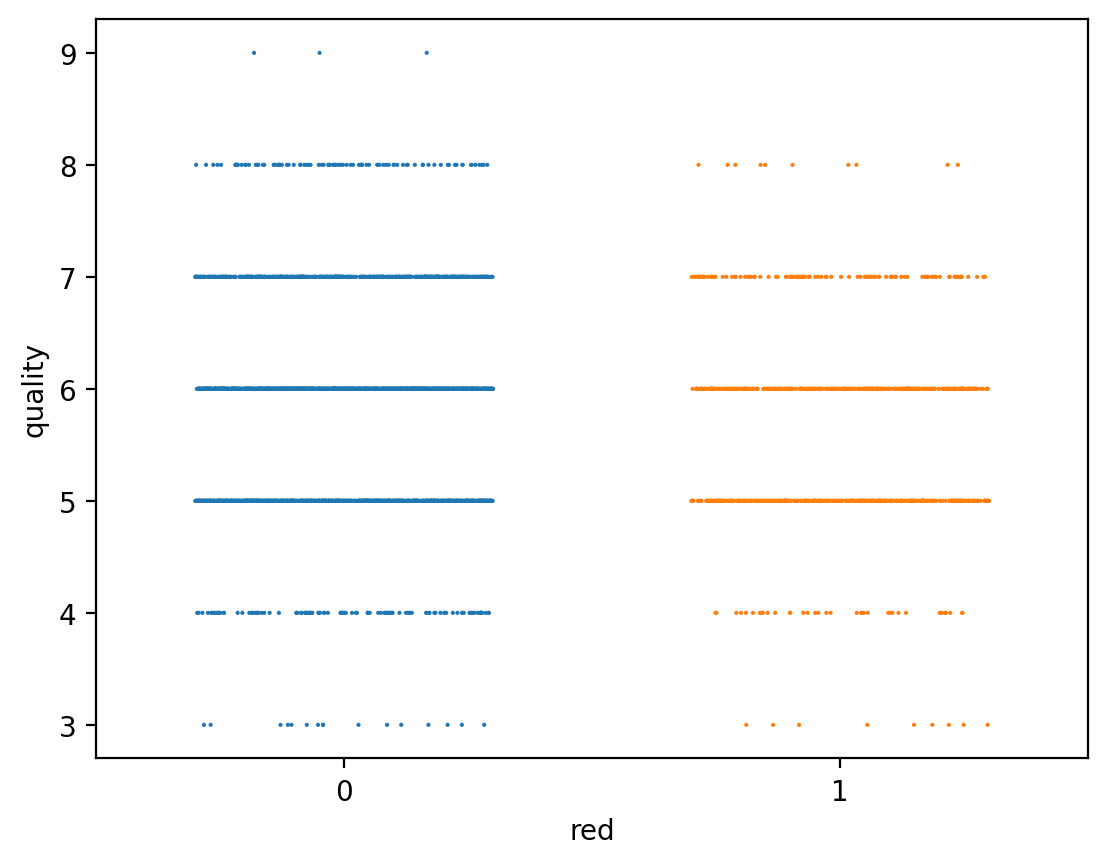

red group quality boxplots


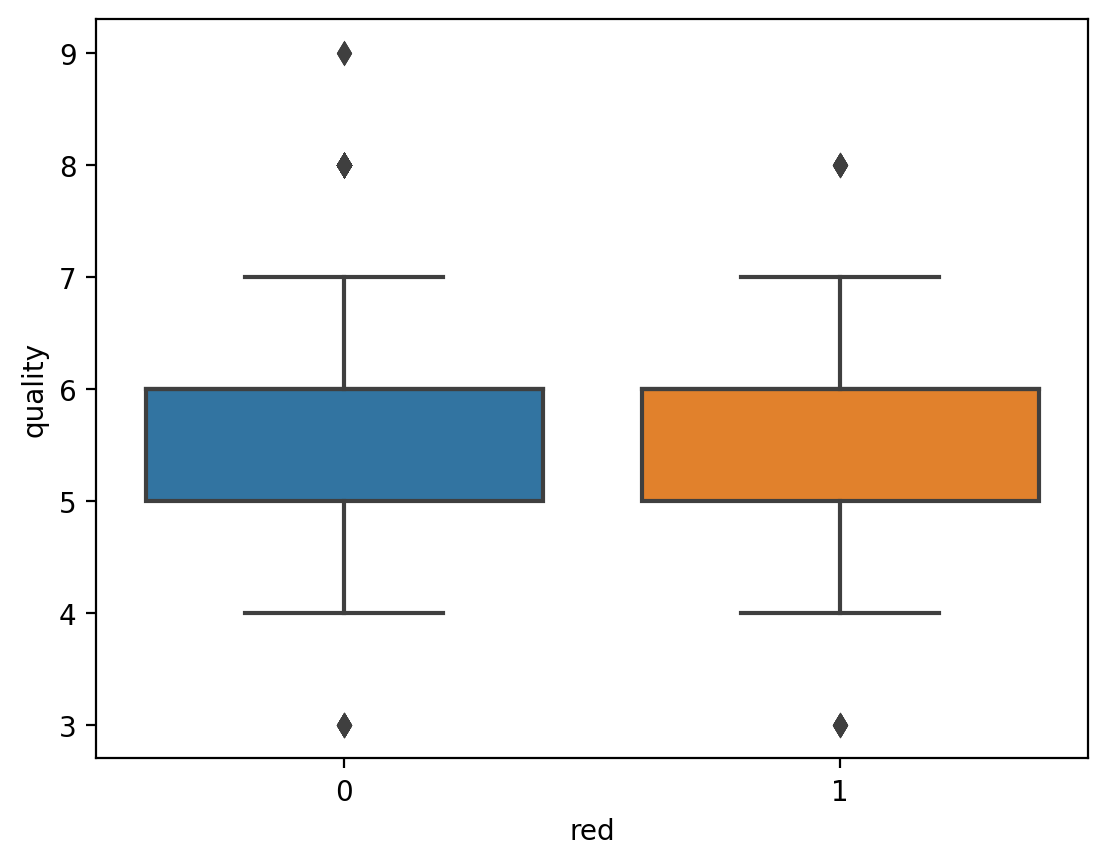

In [6]:
e.explore_bivariate_cat_to_cont_target(train, target='quality',
                                       cat_cols=['red'])

In [7]:
# e.explore_bivariate_cont_to_cont_target(train, target='quality',
#                                         cont_cols=e.get_cat_and_cont_cols(train)[1] + ['quality'])

In [8]:


#.to_frame()[1:]

In [9]:
def plot_key_features():
    df = train
    target='quality'

    plt.figure(figsize=(1.5,5))
    ax = sns.heatmap(df[abs(df.corr()[target]).sort_values(ascending=False).index].corr()[target].to_frame()[1:],
                        annot=True, cmap='RdYlGn', vmin=-1, vmax=1)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(right=False, labelsize=8) 
    cbar.set_ticks([-1, -.5, 0, .5, 1])
    plt.tick_params(axis='both', left=False, bottom=False)

    rectangle = patches.Rectangle((0, 0), 1, 4, linewidth=1.5, edgecolor='#C40000', facecolor='none')
    ax.add_patch(rectangle)

    plt.title('4 Strongest Drivers of Quality')
    plt.show()

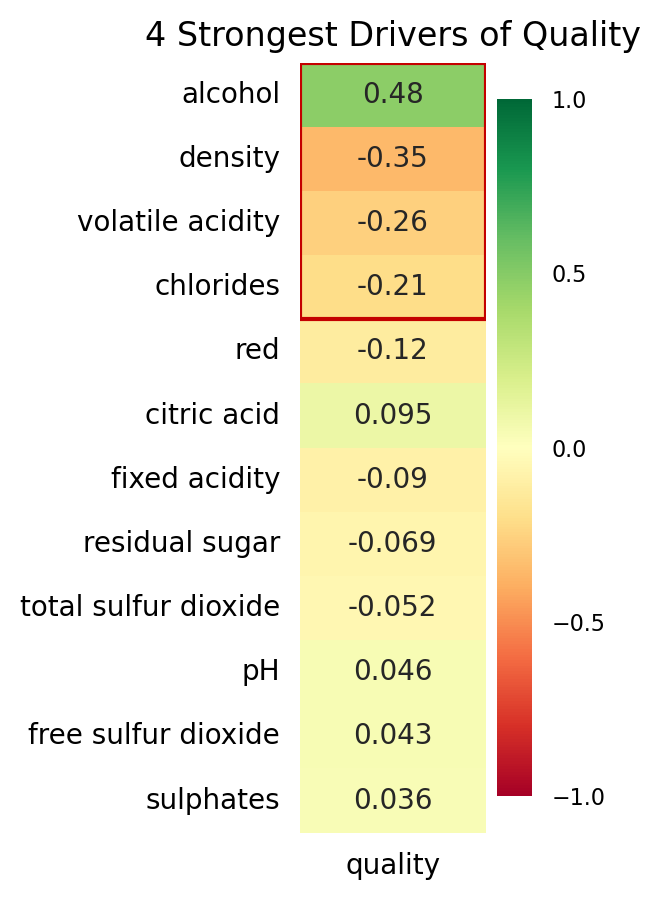

In [10]:
plot_key_features()

In [11]:
def plot_alcohol_by_quality():
    fig, axes = plt.subplots(2, 1, figsize=(6,6))
    sns.barplot(data=train, x='quality', y='alcohol', color='green',
                errorbar=None, ax=axes[0])

    for p in axes[0].patches:
        axes[0].annotate(f'$ {str(round(p.get_height(), 1))}%', 
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=8)

    axes[0].set_xlabel('')

    sns.stripplot(data=train, x='quality', y='alcohol', size=1, 
                  color='green', jitter=.2, ax=axes[1])

    axes[1].set_xlabel('Quality', fontsize=10, labelpad=5)

    plt.suptitle('Higher Quality Wines Have More Alcohol')

    for ax in axes:
        ax.set_ylabel('Alcohol', rotation=0, fontsize=10, labelpad=20)
        ax.tick_params(axis='both', left=False, bottom=False, labelsize=8)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{round(x)}%'))

    sns.despine()
    plt.tight_layout()
    plt.show()

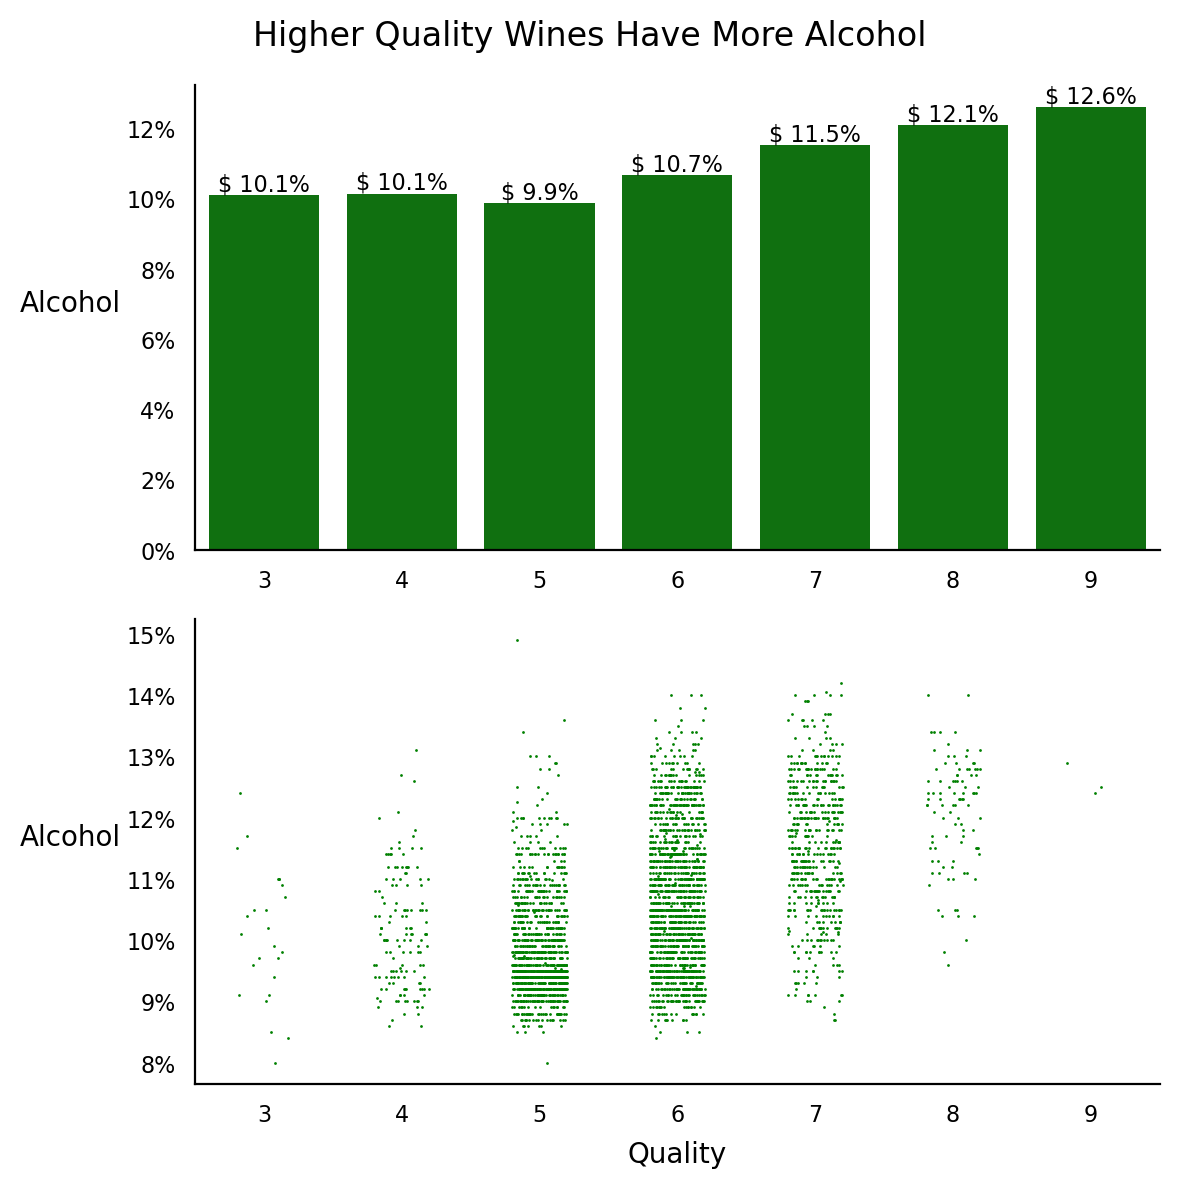

In [12]:
plot_alcohol_by_quality()

**Clustering**

Find clusters/groups from strong features

In [13]:
scaler = MinMaxScaler()

Scale Training data

In [14]:
pd.DataFrame(data=scaler.fit_transform(train.drop(columns=['quality'])),
             columns=train.drop(columns=['quality']).columns)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,red
0,0.289256,0.160000,0.174699,0.029032,0.043406,0.107639,0.317972,0.252264,0.372093,0.171429,0.405797,0.0
1,0.190083,0.060000,0.168675,0.125806,0.035058,0.156250,0.331797,0.266925,0.550388,0.137143,0.420290,0.0
2,0.314050,0.146667,0.150602,0.119355,0.070117,0.072917,0.241935,0.366106,0.310078,0.137143,0.173913,0.0
3,0.214876,0.153333,0.301205,0.167742,0.043406,0.142361,0.241935,0.206123,0.356589,0.160000,0.565217,0.0
4,0.148760,0.120000,0.000000,0.309677,0.043406,0.041667,0.241935,0.260457,0.558140,0.120000,0.637681,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3719,0.347107,0.033333,0.150602,0.016129,0.035058,0.048611,0.184332,0.143596,0.201550,0.080000,0.463768,0.0
3720,0.264463,0.046667,0.228916,0.051613,0.058431,0.111111,0.207373,0.245364,0.317829,0.080000,0.347826,0.0
3721,0.099174,0.200000,0.006024,0.032258,0.060100,0.086806,0.124424,0.160845,0.759690,0.285714,0.869565,1.0
3722,0.355372,0.126667,0.198795,0.022581,0.055092,0.086806,0.216590,0.153083,0.201550,0.108571,0.637681,0.0


In [15]:
train_sc = pd.concat([pd.DataFrame(data=scaler.fit_transform(train.drop(columns=['quality'])),
                                   columns=train.drop(columns=['quality']).columns),
                      train[['quality']].reset_index().iloc[:,1]],
                      axis=1)

In [16]:
train_sc.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,red,quality
0,0.289256,0.160000,0.174699,0.029032,0.043406,0.107639,0.317972,0.252264,0.372093,0.171429,0.405797,0.0,5
1,0.190083,0.060000,0.168675,0.125806,0.035058,0.156250,0.331797,0.266925,0.550388,0.137143,0.420290,0.0,6
2,0.314050,0.146667,0.150602,0.119355,0.070117,0.072917,0.241935,0.366106,0.310078,0.137143,0.173913,0.0,5
3,0.214876,0.153333,0.301205,0.167742,0.043406,0.142361,0.241935,0.206123,0.356589,0.160000,0.565217,0.0,7
4,0.148760,0.120000,0.000000,0.309677,0.043406,0.041667,0.241935,0.260457,0.558140,0.120000,0.637681,0.0,6


In [17]:
validate_sc = pd.concat([pd.DataFrame(data=scaler.transform(validate.drop(columns=['quality'])),
                                   columns=validate.drop(columns=['quality']).columns),
                         validate[['quality']].reset_index().iloc[:,1]],
                         axis=1)

In [18]:
validate_sc.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,red,quality
0,0.429752,0.306667,0.295181,0.074194,0.136895,0.138889,0.239631,0.478223,0.279070,0.205714,0.173913,1.0,5
1,0.413223,0.106667,0.325301,0.061290,0.118531,0.083333,0.117512,0.482536,0.519380,0.165714,0.173913,1.0,5
2,0.338843,0.153333,0.132530,0.409677,0.060100,0.156250,0.474654,0.530832,0.581395,0.194286,0.289855,0.0,5
3,0.223140,0.146667,0.192771,0.045161,0.053422,0.114583,0.193548,0.204398,0.503876,0.245714,0.434783,0.0,7
4,0.256198,0.146667,0.216867,0.125806,0.070117,0.104167,0.453917,0.345839,0.527132,0.182857,0.347826,0.0,4


In [19]:
test_sc = pd.concat([pd.DataFrame(data=scaler.transform(test.drop(columns=['quality'])),
                                   columns=test.drop(columns=['quality']).columns),
                     test[['quality']].reset_index().iloc[:,1]],
                     axis=1)

In [20]:
test_sc.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,red,quality
0,0.198347,0.086667,0.313253,0.190323,0.058431,0.093750,0.269585,0.304873,0.387597,0.137143,0.275362,0.0,6
1,0.314050,0.100000,0.385542,0.396774,0.035058,0.184028,0.377880,0.469599,0.217054,0.160000,0.115942,0.0,5
2,0.239669,0.133333,0.204819,0.267742,0.060100,0.107639,0.241935,0.320828,0.410853,0.165714,0.434783,0.0,7
3,0.338843,0.073333,0.253012,0.032258,0.075125,0.059028,0.055300,0.297111,0.441860,0.251429,0.463768,1.0,6
4,0.247934,0.133333,0.174699,0.364516,0.066778,0.173611,0.329493,0.359207,0.232558,0.188571,0.347826,0.0,6


In [21]:
# plt.figure(figsize=(40,20))

# sns.pairplot(data=train_sc, corner=True,
#              hue='quality', plot_kws={'s': 3, 'alpha': .1})

**Cluster**

- `['alcohol', 'volatile acidity', 'chlorides']`
- `[‘alcohol', ‘density’, 'citric acid’]`
- `[‘alcohol', ‘sugar, ‘ph’]`
- `['Total sulfur dioxide', 'density']`

Cluster on combination of 2 features

In [22]:
len(list(combinations(train_sc.columns, 2)))

78

How well can we cluster off 2 features?
- lower inertia means we have denser clusters
- **Note:** this doesn't tell us how useful these clusters will be at predicting quality.

In [23]:
# for combo in [list(tup) for tup in list(combinations(train_sc.columns, 2))]:
#     print('-'*20)
#     print(combo)
#     plt.figure(figsize=(4, 3))
#     pd.Series({k: KMeans(k).fit(train_sc[combo]).inertia_ for k in range(2, 12)}).plot(marker='x')
#     plt.xticks(range(2, 12))
#     plt.xlabel('k')
#     plt.ylabel('inertia')
#     plt.title('Change in inertia as k increases')
#     plt.show()

Cluster on combination of 3 features

In [24]:
len(list(combinations(train_sc.columns, 3)))

286

How well can we cluster off 3 features?
- lower inertia means we have denser clusters
- **Note:** this doesn't tell us how useful these clusters will be at predicting quality.

In [25]:
# for combo in [list(tup) for tup in list(combinations(train_sc.columns, 3))]:
#     print('-'*20)
#     print(combo)
#     plt.figure(figsize=(4, 3))
#     pd.Series({k: KMeans(k).fit(train_sc[combo]).inertia_ for k in range(2, 12)}).plot(marker='x')
#     plt.xticks(range(2, 12))
#     plt.xlabel('k')
#     plt.ylabel('inertia')
#     plt.title('Change in inertia as k increases')
#     plt.show()

Cluster group 1:

- 4 clusters off `['fixed acidity', 'chlorides', 'alcohol']`

In [26]:
feats1 = ['fixed acidity', 'chlorides', 'alcohol']

kmeans1 = KMeans(n_clusters=4, random_state=123).fit(train_sc[feats1])

train['clusters_1'] = kmeans1.predict(train_sc[feats1])
validate['clusters_1'] = kmeans1.predict(validate_sc[feats1])
test['clusters_1'] = kmeans1.predict(test_sc[feats1])

Cluster group 2:

- 4 clusters off `['fixed acidity', 'alcohol']`

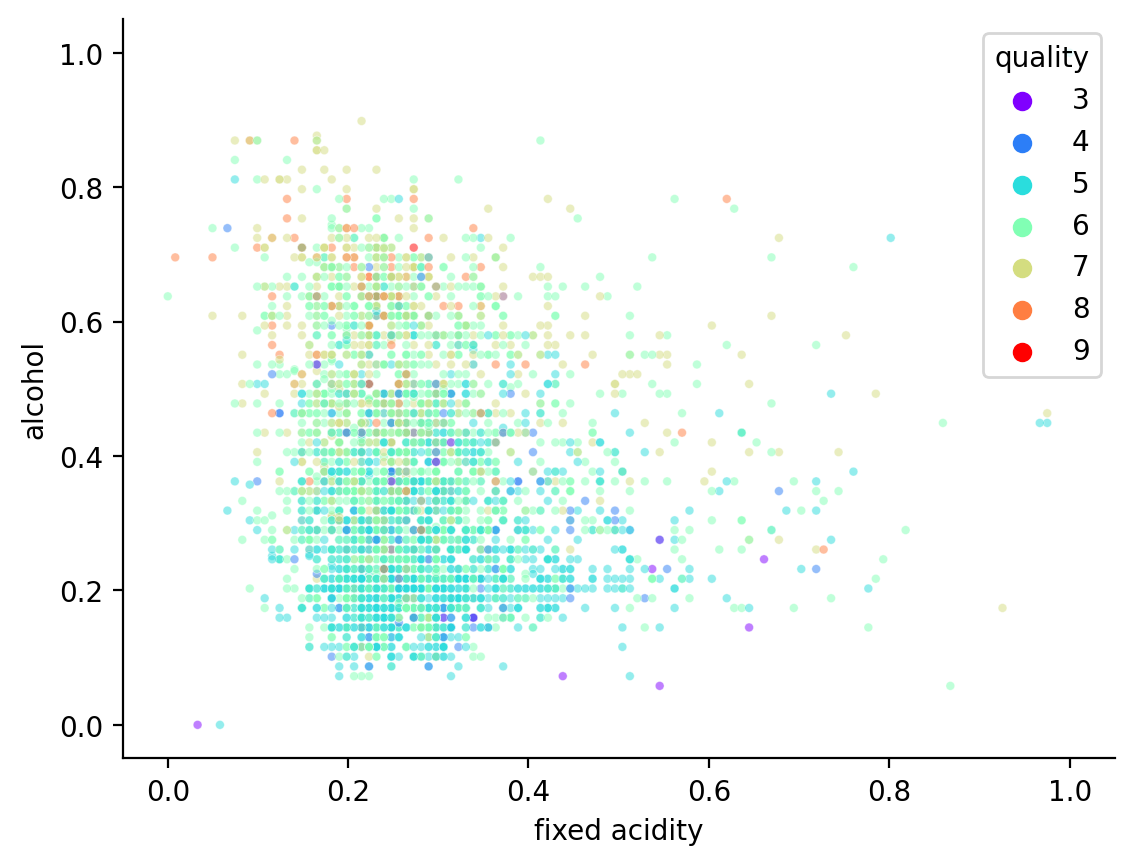

In [67]:
sns.scatterplot(data=train_sc, x='fixed acidity', y='alcohol', hue='quality',
                    s=10, alpha=.5, palette='rainbow')
sns.despine()
plt.show()

In [28]:
feats2 = ['fixed acidity', 'alcohol']

kmeans2 = KMeans(n_clusters=4, random_state=123).fit(train_sc[feats2])

train['clusters_2'] = kmeans2.predict(train_sc[feats2])
validate['clusters_2'] = kmeans2.predict(validate_sc[feats2])
test['clusters_2'] = kmeans2.predict(test_sc[feats2])

Cluster group 3:

- 4 clusters off `['free sulfur dioxide', 'residual sugar', 'alcohol']`

In [29]:
feats3 = ['free sulfur dioxide', 'residual sugar', 'alcohol']

kmeans3 = KMeans(n_clusters=4, random_state=123).fit(train_sc[feats3])

train['clusters_3'] = kmeans3.predict(train_sc[feats3])
validate['clusters_3'] = kmeans3.predict(validate_sc[feats3])
test['clusters_3'] = kmeans3.predict(test_sc[feats3])

Explore Clusters

Cluster 2 in the first group of clusters yields much higher quality.

In [30]:
train.groupby('clusters_1')['quality'].mean()

clusters_1
0    5.611446
1    5.411569
2    6.483333
3    5.882705
Name: quality, dtype: float64

Cluster 2 in the second group of clusters yields much higher quality.

In [31]:
train.groupby('clusters_2')['quality'].mean()

clusters_2
0    5.408847
1    5.881803
2    6.483333
3    5.613095
Name: quality, dtype: float64

Cluster 1 in the third group of clusters yields much higher quality.

In [32]:
train.groupby('clusters_3')['quality'].mean()

clusters_3
0    5.547847
1    6.502865
2    5.386784
3    5.924171
Name: quality, dtype: float64

In [33]:
train['quality'].mean()

5.784371643394199

Save new cluster features onto the original data

In [34]:
df = pd.concat([train, validate, test]).sort_index()
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red,clusters_1,clusters_2,clusters_3
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1,1,0,2
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1,1,0,2
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1,1,0,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1,0,3,2
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,1,1,0,2


Add cluster code to preprocess code in `model.py`

---
Code for extra visualizations:

In [ ]:
def plot_alcohol_by_quality():
    fig, axes = plt.subplots(2, 1, figsize=(6,6))
    sns.barplot(data=train, x='quality', y='alcohol', color='green',
                errorbar=None, ax=axes[0])

    for p in axes[0].patches:
        axes[0].annotate(f'$ {str(round(p.get_height(), 1))}%', 
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=8)

    axes[0].set_xlabel('')

    sns.stripplot(data=train, x='quality', y='alcohol', size=1, 
                  color='green', jitter=.2, ax=axes[1])

    axes[1].set_xlabel('Quality', fontsize=10, labelpad=5)

    plt.suptitle('Higher Quality Wines Have More Alcohol')

    for ax in axes:
        ax.set_ylabel('Alcohol', rotation=0, fontsize=10, labelpad=20)
        ax.tick_params(axis='both', left=False, bottom=False, labelsize=8)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{round(x)}%'))

    sns.despine()
    plt.tight_layout()
    plt.show()

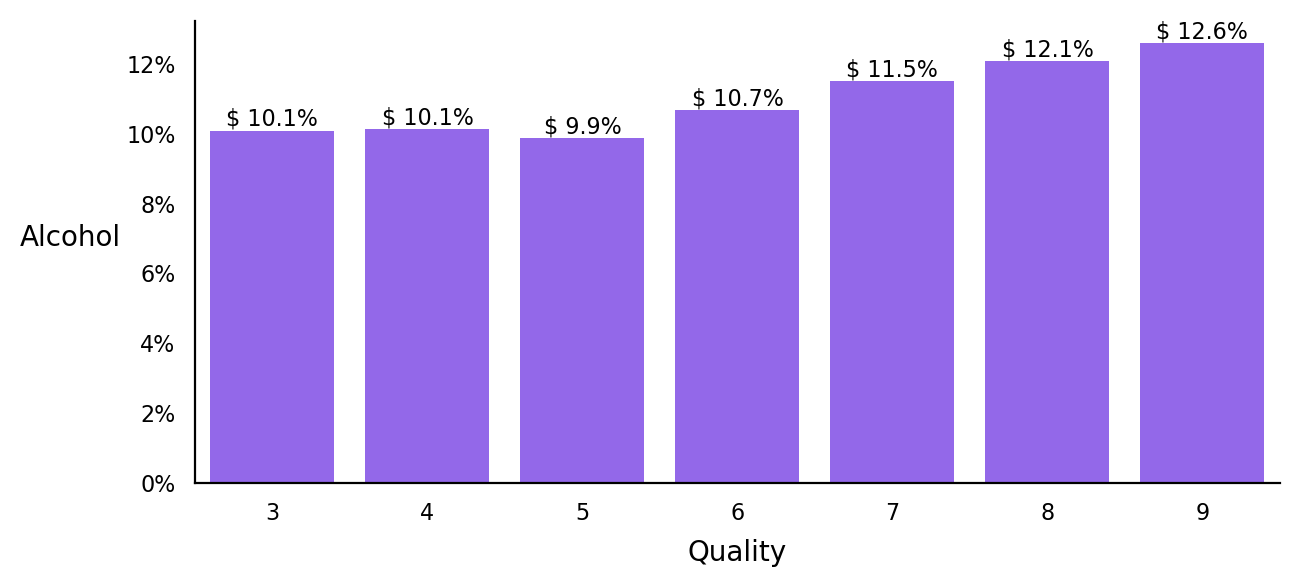

In [48]:
plt.figure(figsize=(7,3))
sns.barplot(data=train, x='quality', y='alcohol', color='#8c52ff',
            errorbar=None)

ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'$ {str(round(p.get_height(), 1))}%', 
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=8)
    
ax.set_xlabel('Quality', fontsize=10, labelpad=5)
ax.set_ylabel('Alcohol', rotation=0, fontsize=10, labelpad=20)
ax.tick_params(axis='both', left=False, bottom=False, labelsize=8)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{round(x)}%'))

sns.despine()

In [54]:
train.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'red', 'clusters_1',
       'clusters_2', 'clusters_3'],
      dtype='object')

In [53]:
train['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'].corr()['quality']

fixed acidity          -0.090492
volatile acidity       -0.262859
citric acid             0.095446
residual sugar         -0.069154
chlorides              -0.207102
free sulfur dioxide     0.043015
total sulfur dioxide   -0.052219
density                -0.353587
pH                      0.046091
sulphates               0.036239
alcohol                 0.483713
quality                 1.000000
red                    -0.122710
clusters_1              0.241693
clusters_2              0.297211
clusters_3              0.011375
Name: quality, dtype: float64

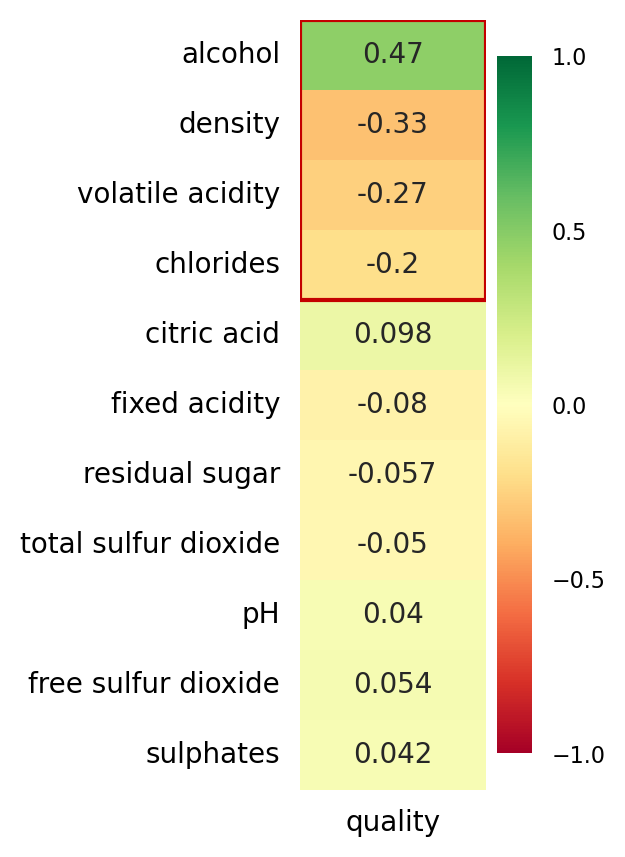

In [56]:
plt.figure(figsize=(1.5,5))
ax = sns.heatmap(train[abs(train[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
                               'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
                               'pH', 'sulphates', 'alcohol', 'quality']].corr()['quality']).sort_values(ascending=False).index].corr()['quality'].to_frame()[1:],
                    annot=True, cmap='RdYlGn', vmin=-1, vmax=1)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(right=False, labelsize=8) 
cbar.set_ticks([-1, -.5, 0, .5, 1])
plt.tick_params(axis='both', left=False, bottom=False)

rectangle = patches.Rectangle((0, 0), 1, 4, linewidth=1.5, edgecolor='#C40000', facecolor='none')
ax.add_patch(rectangle)


plt.show()

In [66]:
from scipy import stats
for col in ['alcohol', 'density', 'volatile acidity', 'chlorides', 'citric acid',
               'fixed acidity', 'residual sugar', 'total sulfur dioxide', 'pH',
               'free sulfur dioxide', 'sulphates']:
    r_stat, p_val = stats.pearsonr(train['quality'], train[col])
    print(round(p_val,2))
    

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.01
0.03
